In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

import tol_colors
from scipy.interpolate import interp1d
from scipy.signal import convolve


In [229]:
# before this, will need to save variables tg1t, z1t, ne1t, pg1t, q, nq, qnorm, outintt, nmu to save file... or access some other way
#filename='/Users/coletamburri/Desktop/radyn_15_8_5e10.sav'
#filename='/Users/coletamburri/Desktop/August_2022_Observations_Paper/radynout.sav'
filename = '/Users/coletamburri/Desktop/15_8_5e10_wRC.sav'
filename_dkist = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/dkist_obs_file.npz'

# change based on desired line and fwhm of observations

kr=16 #Ca II H - 20 is Ca II 8542
timesinit = [0,66.7,133.3,200,250,430,500] #times to print out in plots, in decaseconds
 #decay phase times to print out in plots - will be concatenated to timesinit array
lamb0=396.8 # change this and the instances below to wavelength of spectral line in nm as desired (as needed)
c=2.99e5
mu=.5 #viewing angle cos(theta) - choose between 0.05, 0.23, 0.5, 0.77, 0.95
muind = 2 # index corresponding to the value above; 0=0.05, 1=0.23, 2=0.5, 3=0.77, 4=0.95
fwhm=.05 #dkist FWHM
ntw=45 # DKIST NTW


In [231]:
timesinit

[0, 66.7, 133.3, 200, 250, 430, 500]

In [233]:
read = readsav(filename)

In [235]:
#dkist_file = np.load(filename_dkist)
#dkist_wl = dkist_file['arr_2']

In [237]:
read

{'q': array([[ -10.        ,   -9.9       ,   -9.8       , ...,    9.8       ,
            9.9       ,   10.        ],
        [ -10.        ,   -9.9       ,   -9.8       , ...,    9.8       ,
            9.9       ,   10.        ],
        [-202.25406445, -128.8242093 ,  -85.24716111, ...,   85.24716111,
          128.8242093 ,  202.25406445],
        ...,
        [   3.86456117,  315.26158432,  667.54088934, ...,    0.        ,
            0.        ,    0.        ],
        [   0.89786922,  285.96012921,  607.6837965 , ...,    0.        ,
            0.        ,    0.        ],
        [   1.62889359,  286.70008534,  608.43383309, ...,    0.        ,
            0.        ,    0.        ]], dtype='>f8'),
 'nq': array([201, 201, 201, 201, 201, 201, 201, 201, 201, 201,   7,  28,  13,
          6,   6,   4, 101, 101, 101, 101, 101,   6,   8,   8,   8,   8,
         51,  51, 101,  51,  51,  51,  51,  33,   5,   6,   8,   9,  24,
         34,  34], dtype='>i4'),
 'qnorm': 12.85,
 'outint

In [239]:
np.shape(read['tg1t'])

(682, 191)

In [241]:
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu2

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr
#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range,ntw,gaussian_psf):
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    dw=new_dispersion_range[1]-new_dispersion_range[0]
    dw=dw
    tw=(np.arange(ntw)-ntw//2)*dw
    
    for i in range(1):

    	psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    	yconv = convolve(yatlas, psf, mode='same', method='fft')
        
    return yconv


def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.AA)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

In [243]:
i

29

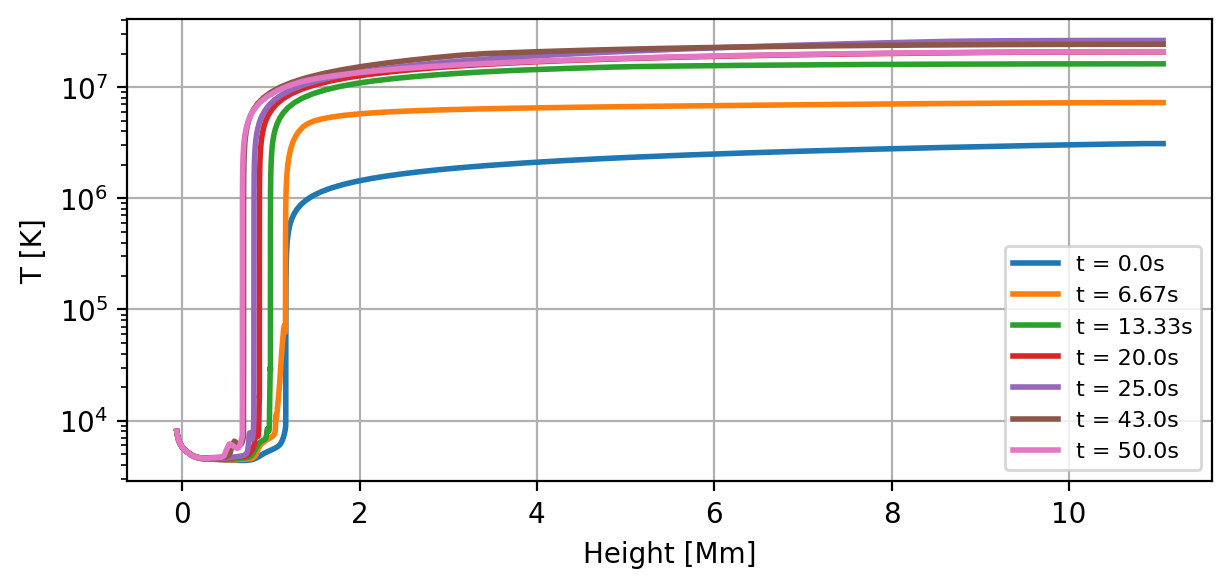

In [245]:
ncol2 = len(timesinit)#+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read['z1t'][int(timesinit[i]),:]/1e8,(read['tg1t'][int(timesinit[i]),:]),label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

#for i in range(len(times2)):
#    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['tg1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
#ax.set_xlim([0,10])
plt.yscale('log')

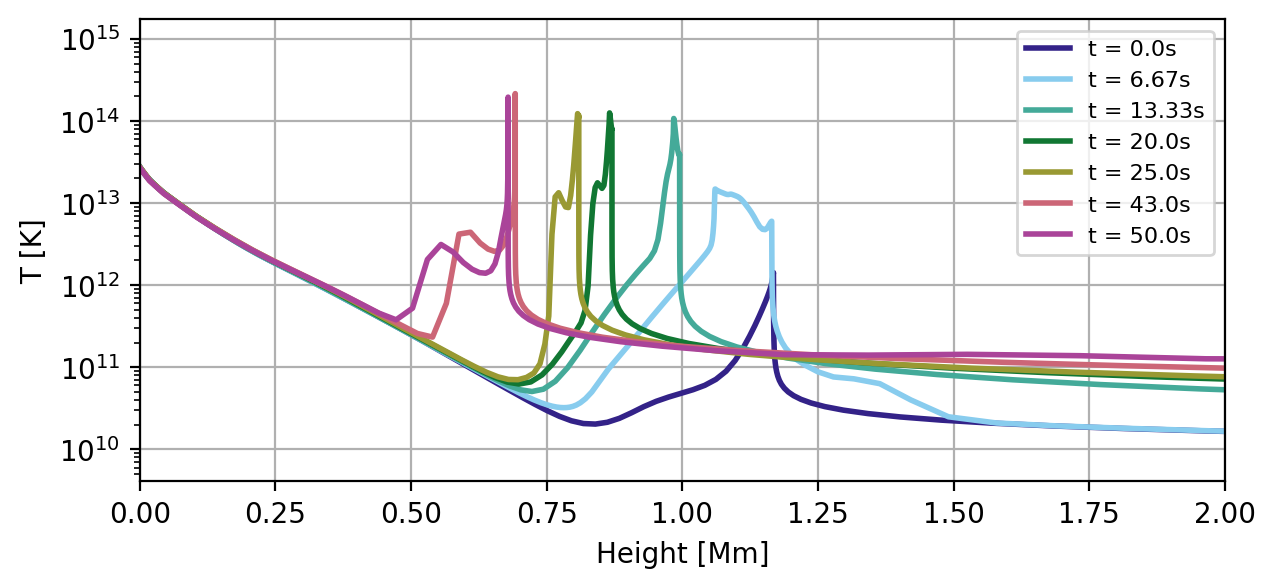

In [247]:


ncol2 = len(timesinit)#+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read['z1t'][int(timesinit[i]),:]/1e8,(read['ne1t'][int(timesinit[i]),:]),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

#for i in range(len(times2)):
#    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['ne1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,2])
plt.yscale('log')

In [249]:
filename2='/Users/coletamburri/Desktop/chosenvel.sav'
read2 = readsav(filename2)

In [251]:
read2['vz1t']

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  8.60163522e-01,  3.99456196e-01, ...,
         2.90640844e-03,  2.16823976e-03,  0.00000000e+00],
       [ 0.00000000e+00,  1.53556169e+00,  7.93426513e-01, ...,
         1.45438503e-02,  5.75330613e-03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -3.71252093e+05, -6.76370891e+05, ...,
        -3.60613986e+00, -1.98184705e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.41231222e+05, -6.21990418e+05, ...,
        -3.54705828e+00, -1.94271908e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.07091748e+05, -5.63582138e+05, ...,
        -3.48204460e+00, -1.90363866e+00,  0.00000000e+00]], dtype='>f8')

ValueError: x and y must have same first dimension, but have shapes (191,) and (300,)

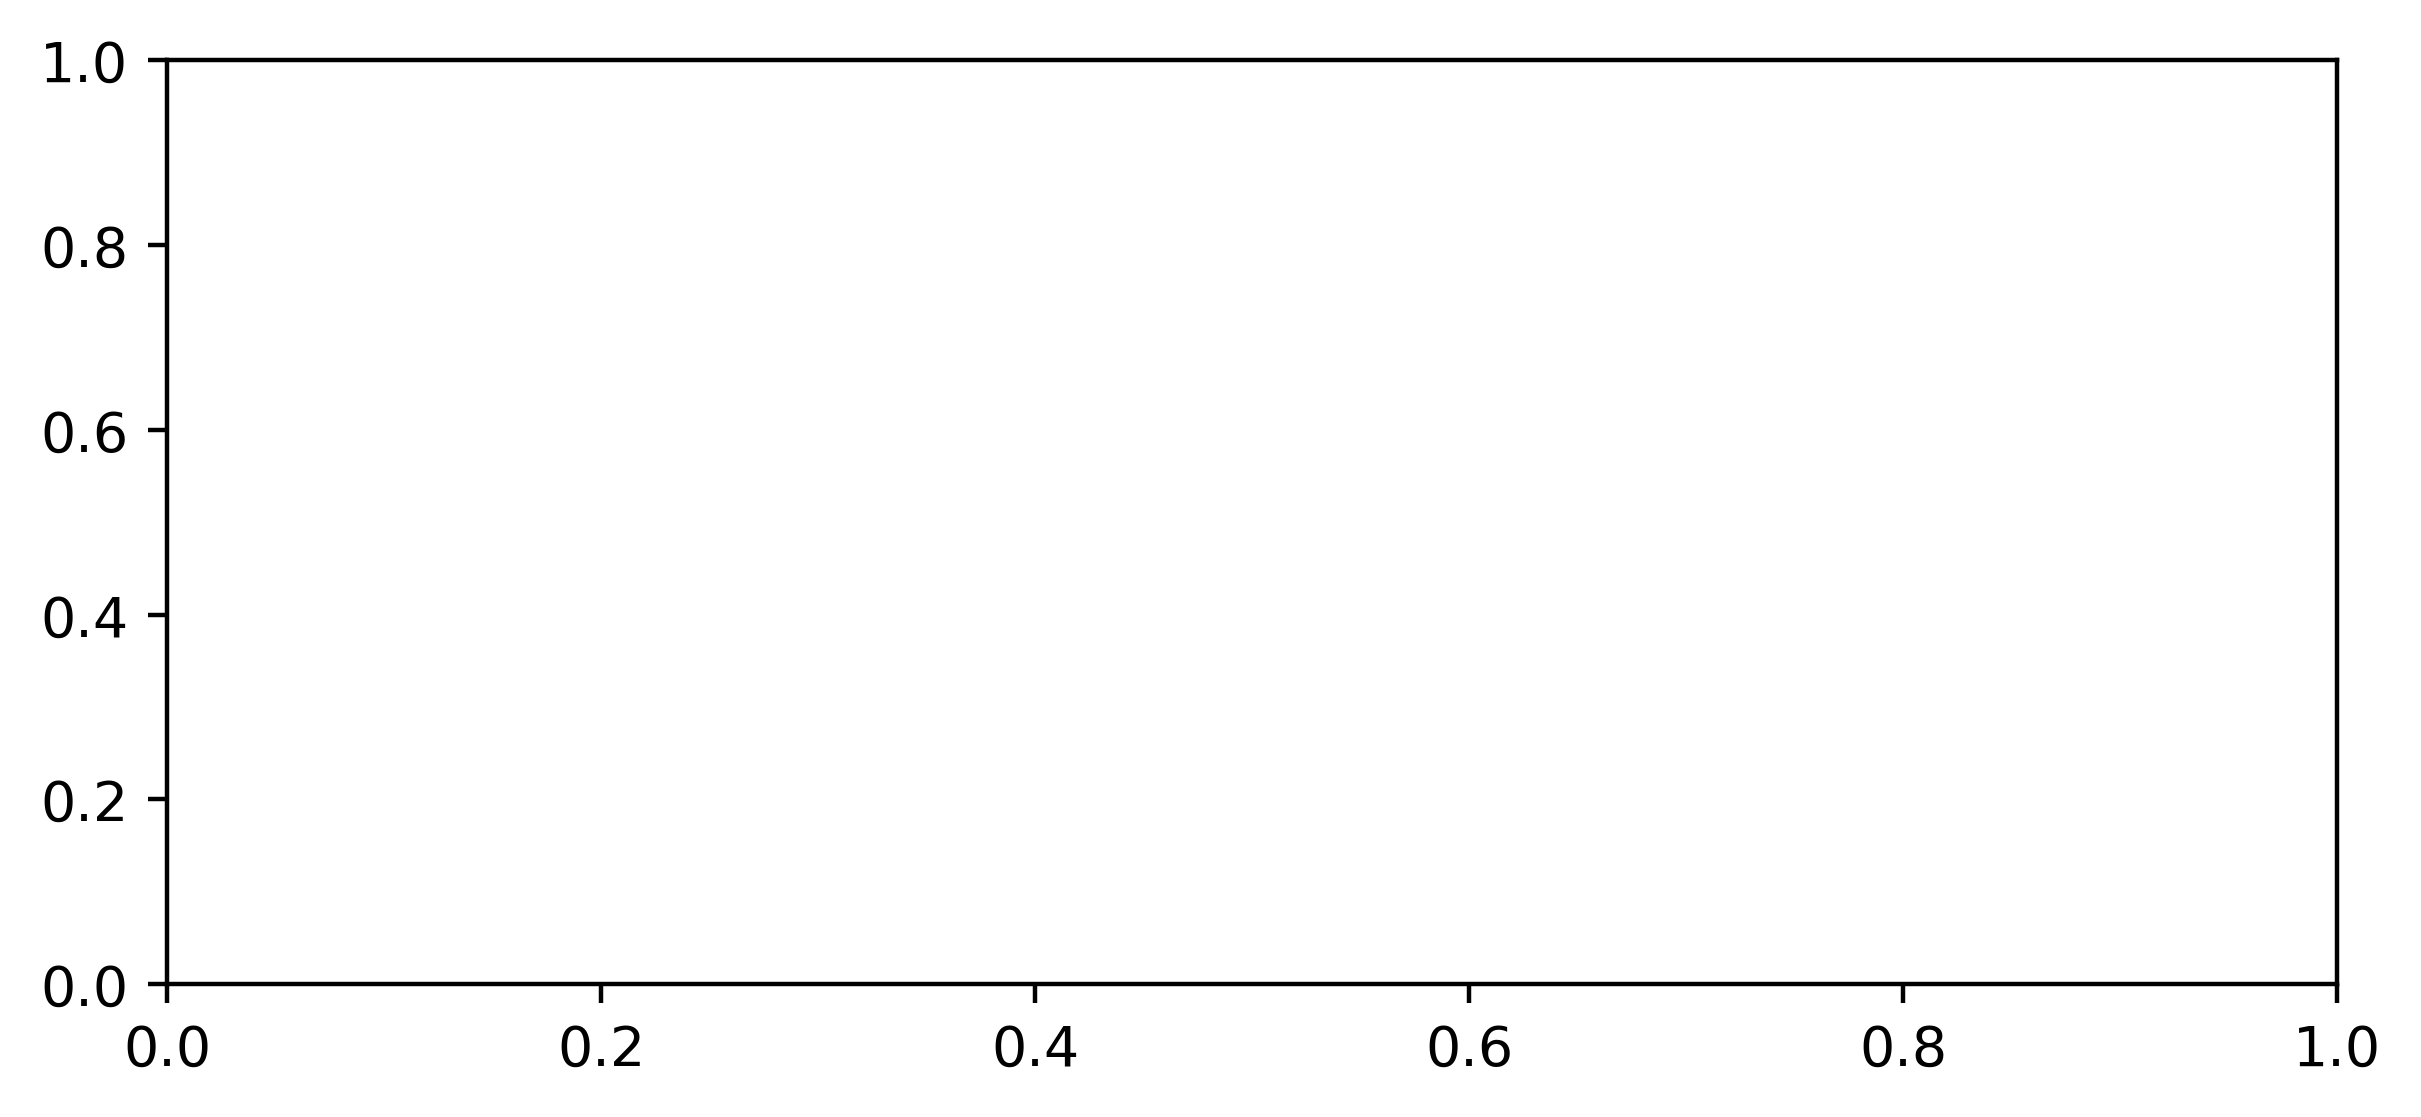

In [253]:


ncol2 = len(timesinit)#+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']

fig,ax=plt.subplots(dpi=400,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read['z1t'][int(timesinit[i]),:]/1e8,(read2['vz1t'][int(timesinit[i]),:])/1e5,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

#for i in range(len(times2)):
#    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['ne1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
#ax.legend(fontsize=8,loc='lower left')
ax.set_ylabel(r'$v_z\; [km\;s^{-1}]$')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,2])
ax.set_ylim([-35,200])
#plt.yscale('log')

In [256]:
def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

In [258]:
# I think 1.9e11 is the conversion...

In [260]:
q = read['q']
nq = read['nq']
qnorm = read['qnorm']
outintt = read['outintt']
nmu = read['nmu']
#q[0:nq[kr]-1,kr]*qnorm,outintt[1:nq[kr],nmu-1,kr,*]

In [262]:
timesinit

[0, 66.7, 133.3, 200, 250, 430, 500]

In [264]:
import label

ModuleNotFoundError: No module named 'label'

In [266]:
len(outintt[int(timesinit[i]),kr,muind,:-101])

101

[]

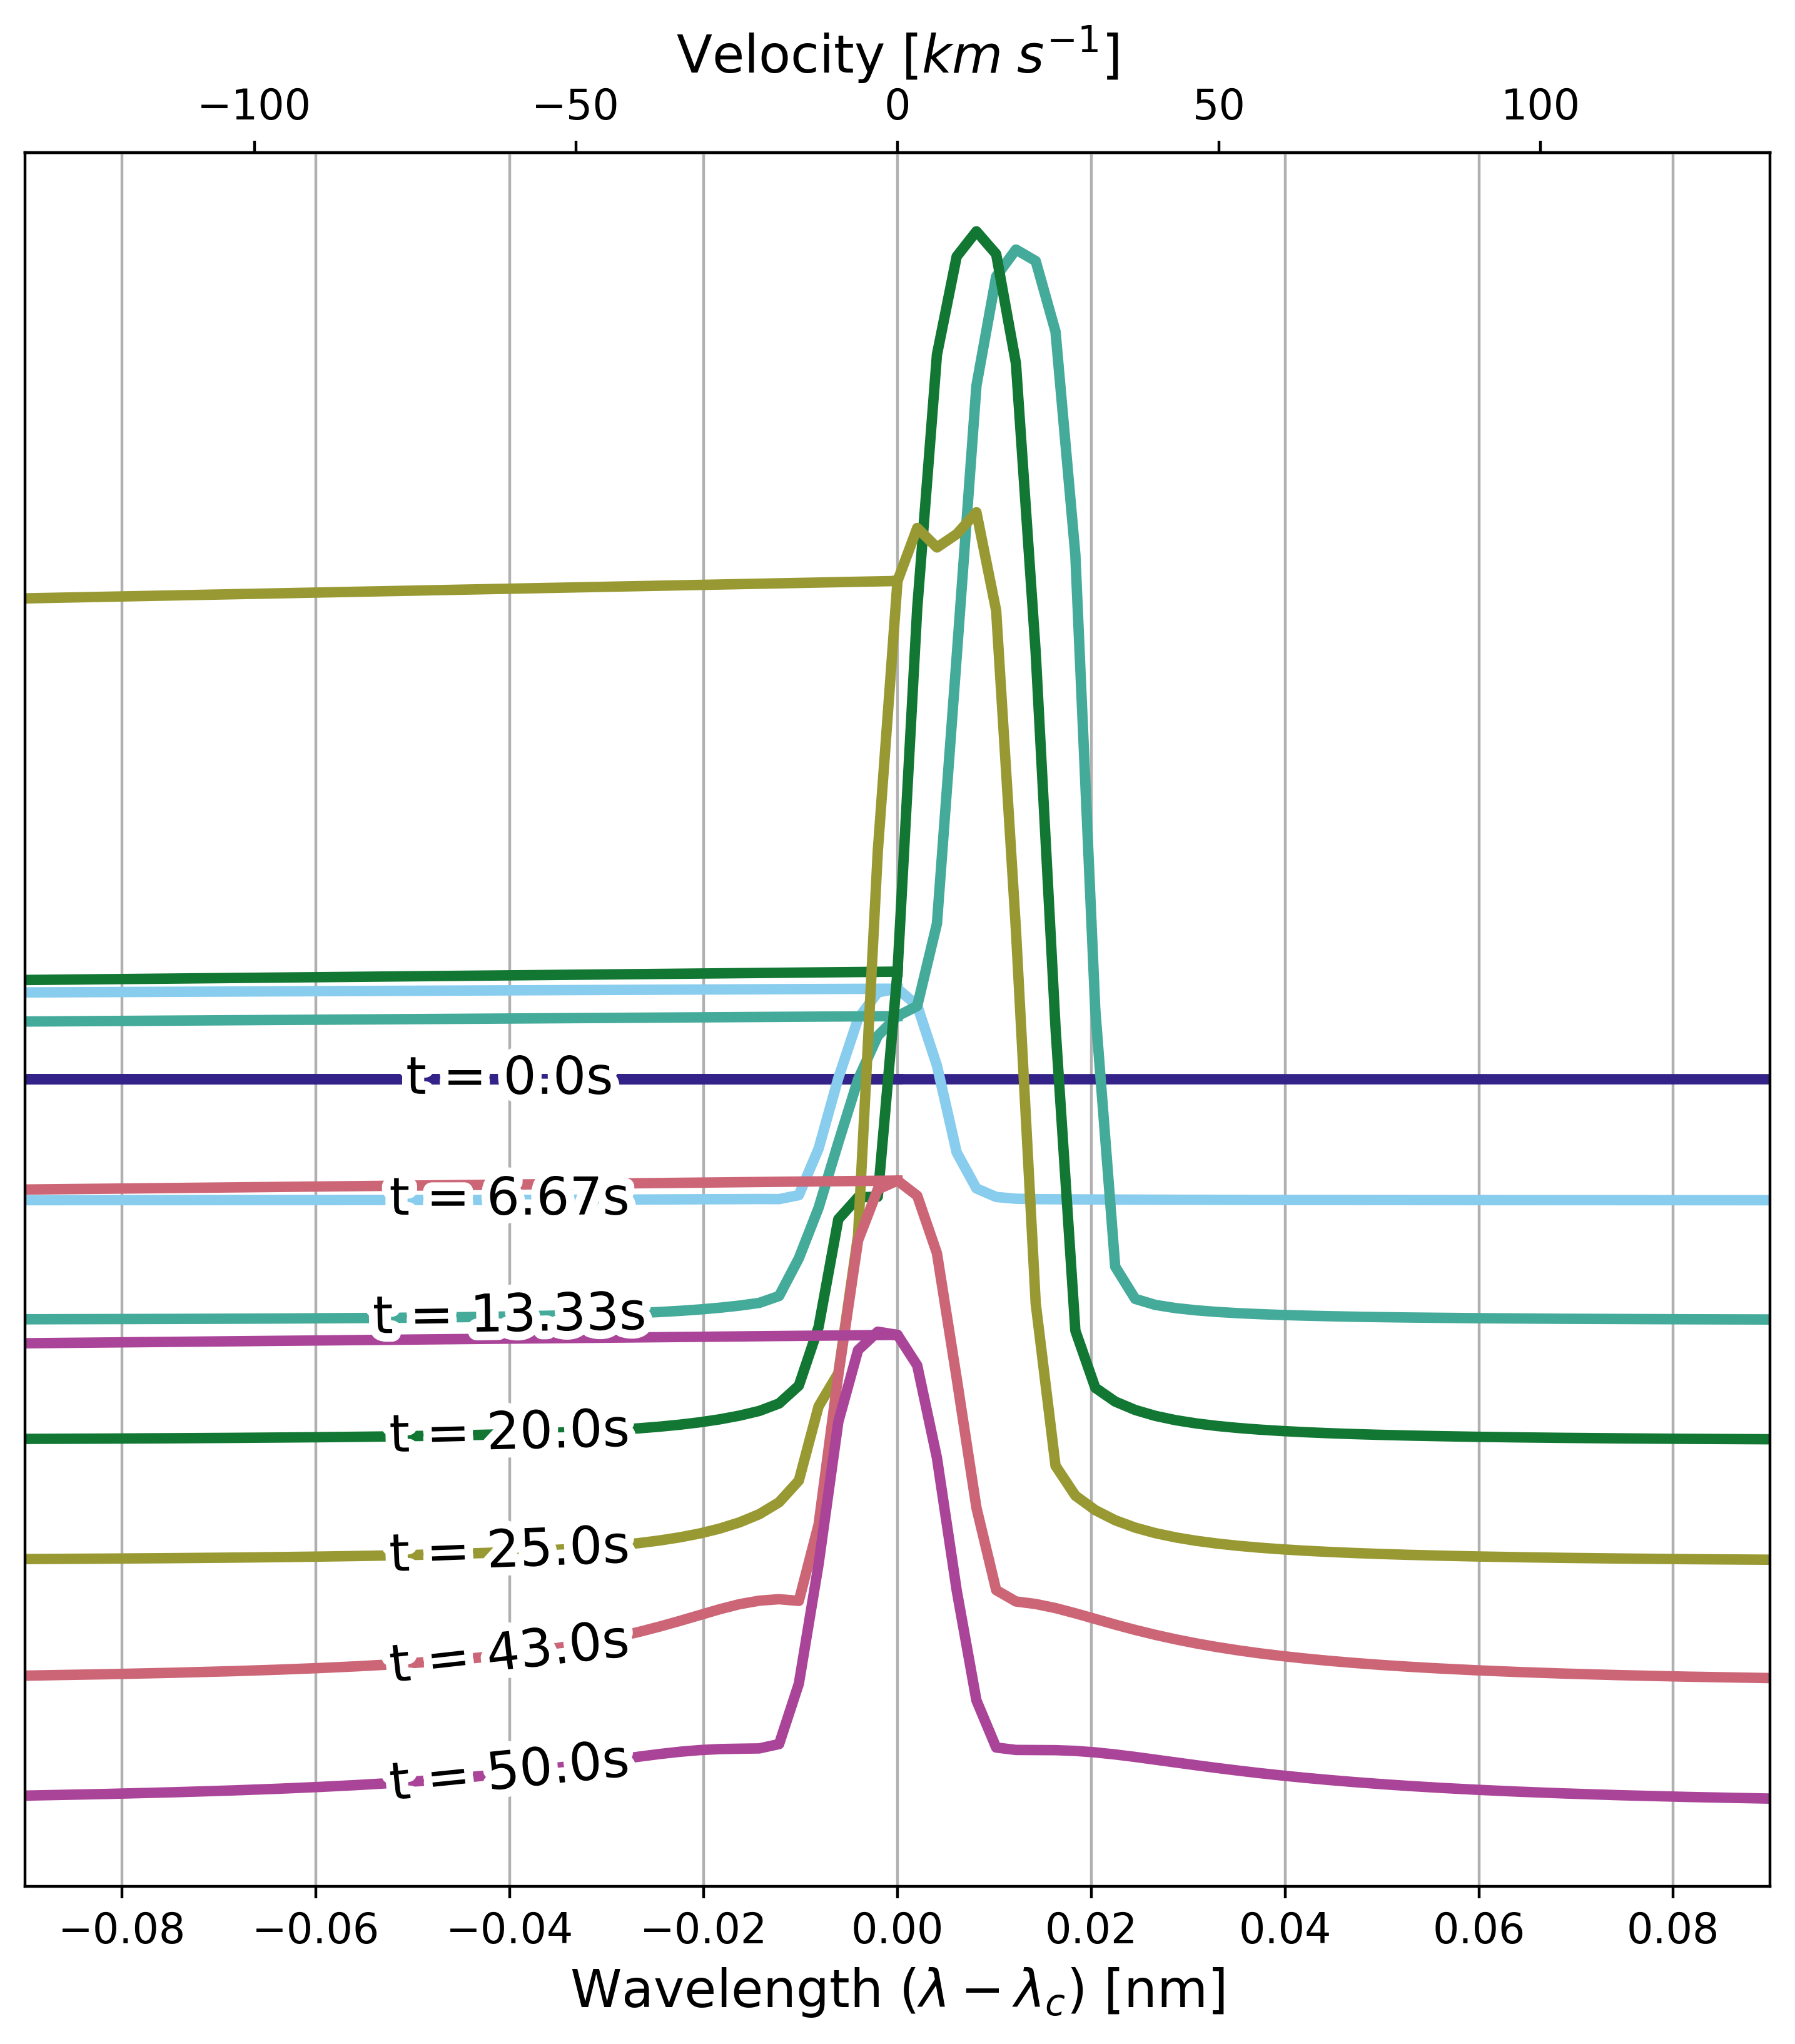

In [268]:


cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']
#cmap_choice2 = plt.cm.jet(np.linspace(0,1,len(timesinit)))

wavelengths = (doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm))

fig,ax=plt.subplots(figsize=(9,9),dpi=400)
for i in range(len(timesinit)):
    #if i==2:
    #    #ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),marker='o',color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
    #    ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt[int(timesinit[0]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[-i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)

    #else:
    ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt[int(timesinit[0]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
       
    ax.set_xlim([.09,-.09])
xvals = np.zeros(30)
for i in range(len(xvals)):
    xvals[i] = -0.04
labelLines(plt.gca().get_lines(),align=True,xvals=xvals,color='k',fontsize=15)

#for i in range(len(times2)):
#    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
#ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$',fontsize=15)
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
secaxx.tick_params(axis='both', which='major', labelsize=12)
#ax.yaxis.
ax.yaxis.set_ticks([])

In [83]:
!pip install matplotlib-label-lines

In [248]:
lines = plt.gca().get_lines()
l1=lines[-1]
labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
labelLines(lines[:-1],align=False)

SyntaxError: invalid syntax (1943292161.py, line 1)

In [85]:
from labellines import *